# Interictal Spikes Analysis

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SEIZURE_BUFFER_TIME = 5  # hours

In [2]:
patient_hup_id = 210
fs = 1024

In [3]:
seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{patient_hup_id}.npy"))
seizure_times_samples = seizure_times_sec * fs
seizure_times_samples = seizure_times_samples.astype(int)
seizure_times_samples

array([[610603038, 610676613],
       [791951319, 792104919]])

In [4]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP210_phaseII_562.npy,562,69058560
1,HUP210_phaseII_576.npy,576,70778880
2,HUP210_phaseII_577.npy,577,70901760
3,HUP210_phaseII_586.npy,586,72007680
4,HUP210_phaseII_589.npy,589,72376320
...,...,...,...
4797,HUP210_phaseII_5519.npy,5519,678174720
4798,HUP210_phaseII_5520.npy,5520,678297600
4799,HUP210_phaseII_5521.npy,5521,678420480
4800,HUP210_phaseII_5522.npy,5522,678543360


In [5]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index,channel_index,sequence_index
0,69114386,40,0
1,69114427,0,0
2,69116031,40,1
3,69116031,39,1
4,70886208,0,0
...,...,...,...
530694,678782841,42,12
530695,678782841,43,12
530696,678782841,44,12
530697,678782841,40,12


In [6]:
# Calculate the buffer time in samples
buffer_samples = SEIZURE_BUFFER_TIME * 3600 * fs

# Create a mask to determine which rows to keep
mask = np.ones(len(all_spikes_df), dtype=bool)
for start, end in seizure_times_samples:
    mask &= ~(
        (all_spikes_df["peak_index"] >= start - buffer_samples)
        & (all_spikes_df["peak_index"] <= end + buffer_samples)
    )

# Use the mask to filter rows
interictal_spikes_df = all_spikes_df.copy()[mask]

# reset index
interictal_spikes_df.reset_index(drop=True, inplace=True)

interictal_spikes_df

,peak_index,channel_index,sequence_index
0,69114386,40,0
1,69114427,0,0
2,69116031,40,1
3,69116031,39,1
4,70886208,0,0
...,...,...,...
510980,678782841,42,12
510981,678782841,43,12
510982,678782841,44,12
510983,678782841,40,12


## Raster plot

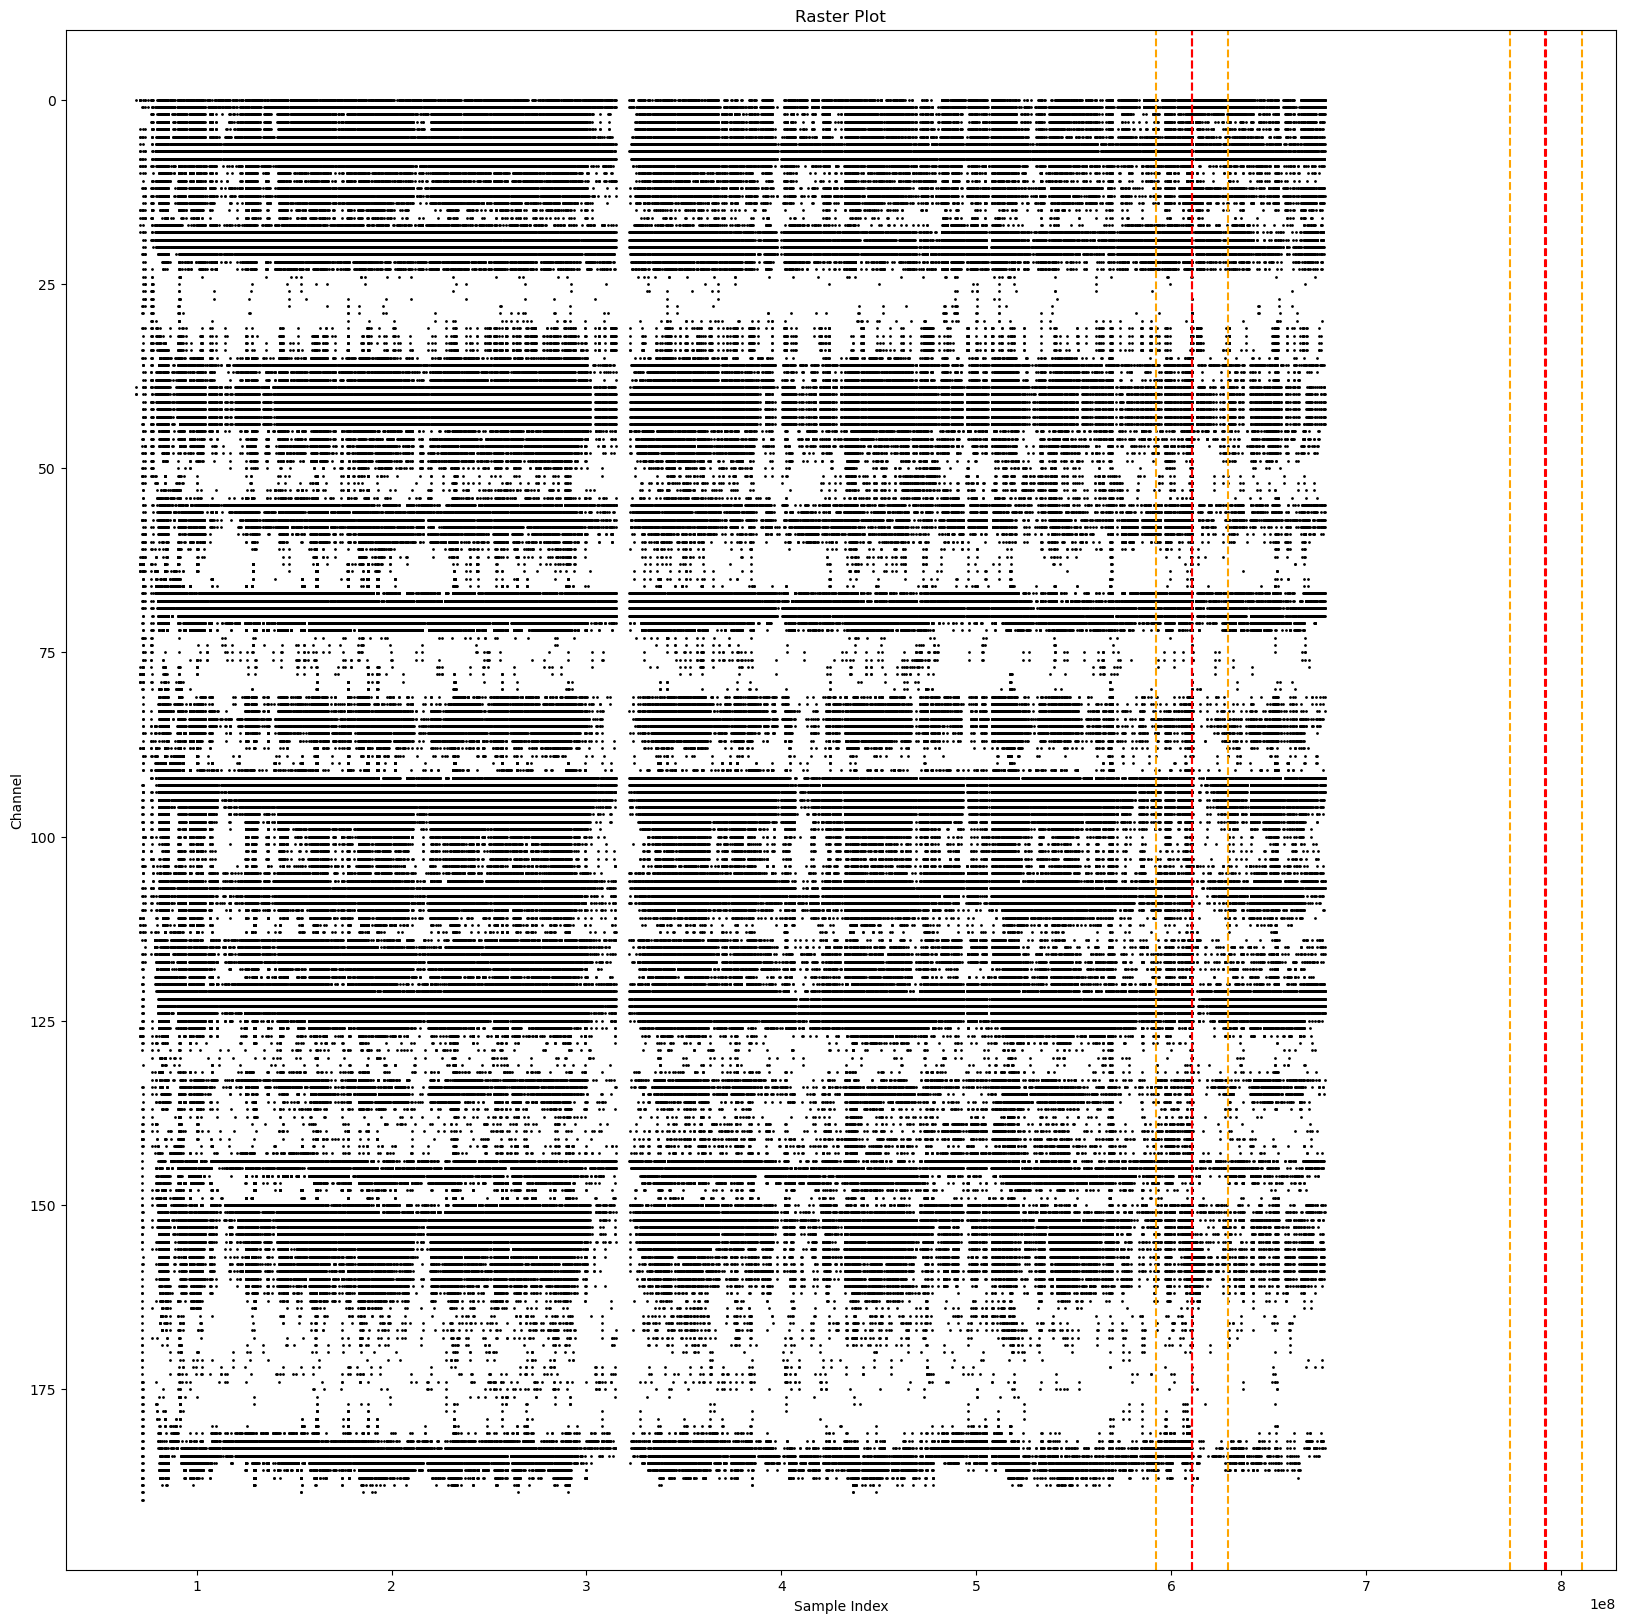

In [12]:
def raster_plot(df, seizure_times, buffer_samples):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Iterate through unique channels
    for channel in df["channel_index"].unique():
        # Extract spike times for this channel
        spike_times = df[df["channel_index"] == channel]["peak_index"]
        ax.plot(spike_times, [channel] * len(spike_times), "k.", markersize=2)

    # Plot vertical dashed lines for seizure times
    for start, end in seizure_times:
        ax.axvline(start, color="r", linestyle="--")
        ax.axvline(end, color="r", linestyle="--")

    # Plot vertical dashed lines for seizure times
    for start, end in seizure_times:
        ax.axvline(start - buffer_samples, color="orange", linestyle="--")
        ax.axvline(end + buffer_samples, color="orange", linestyle="--")

    ax.set_ylabel("Channel")
    ax.set_xlabel("Sample Index")
    ax.set_title("Raster Plot")
    ax.invert_yaxis()  # Optional: to have channel 0 at the top
    plt.show()


raster_plot(all_spikes_df, seizure_times_samples, buffer_samples)

## Inter-spike intervals

In [8]:
# Calculate the inter-spike interval
interictal_spikes_df["inter_spike_interval_samples"] = interictal_spikes_df[
    "peak_index"
].diff()

# If you want to handle the NaN value for the first row (since there's no previous spike to compare to):
interictal_spikes_df.loc[
    0, "inter_spike_interval_samples"
] = 0  # or any other suitable value

# Convert the inter_spike_interval_samples column to integer
interictal_spikes_df["inter_spike_interval_samples"] = interictal_spikes_df[
    "inter_spike_interval_samples"
].astype(int)

interictal_spikes_df["inter_spike_interval_ms"] = (
    interictal_spikes_df["inter_spike_interval_samples"] / fs * 1000
).astype(int)

interictal_spikes_df["inter_spike_interval_sec"] = (
    interictal_spikes_df["inter_spike_interval_samples"] / fs
).astype(int)

interictal_spikes_df.head(10)

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_ms,inter_spike_interval_sec
0,69114386,40,0,0,0,0
1,69114427,0,0,41,40,0
2,69116031,40,1,1604,1566,1
3,69116031,39,1,0,0,0
4,70886208,0,0,1770177,1728688,1728
5,70886214,18,0,6,5,0
6,70886217,16,0,3,2,0
7,70886222,17,0,5,4,0
8,70893337,10,1,7115,6948,6
9,70893339,6,1,2,1,0


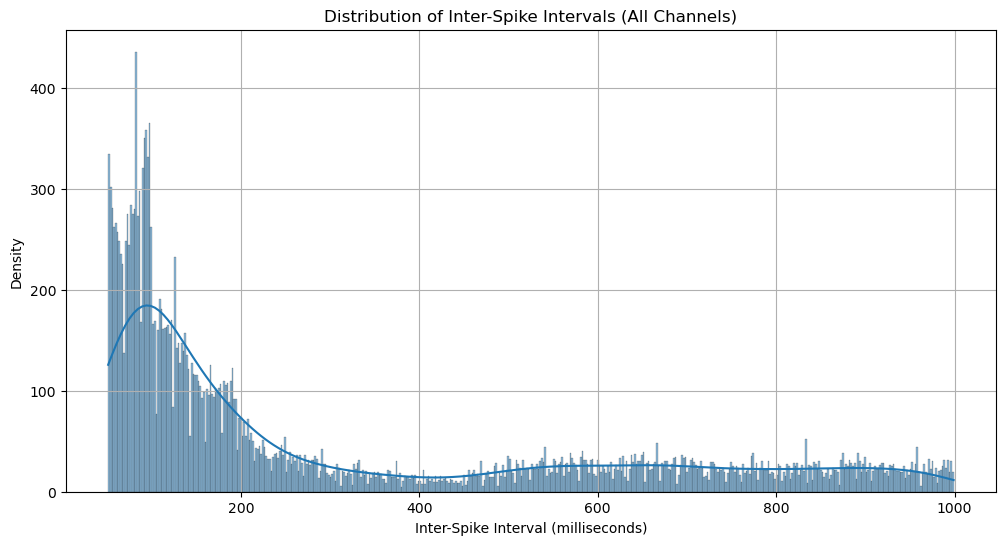

In [9]:
# Create a copy of all_spikes_df called interictal_spikes_df_copy_1

interictal_spikes_df_copy_1 = interictal_spikes_df.copy()

interictal_spikes_df_copy_1 = interictal_spikes_df_copy_1[
    interictal_spikes_df_copy_1["inter_spike_interval_ms"] > 50
]
interictal_spikes_df_copy_1 = interictal_spikes_df_copy_1[
    interictal_spikes_df_copy_1["inter_spike_interval_ms"] < 1000
]

plt.figure(figsize=(12, 6))
sns.histplot(interictal_spikes_df_copy_1["inter_spike_interval_ms"], kde=True, bins=500)
plt.title("Distribution of Inter-Spike Intervals (All Channels)")
plt.xlabel("Inter-Spike Interval (milliseconds)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

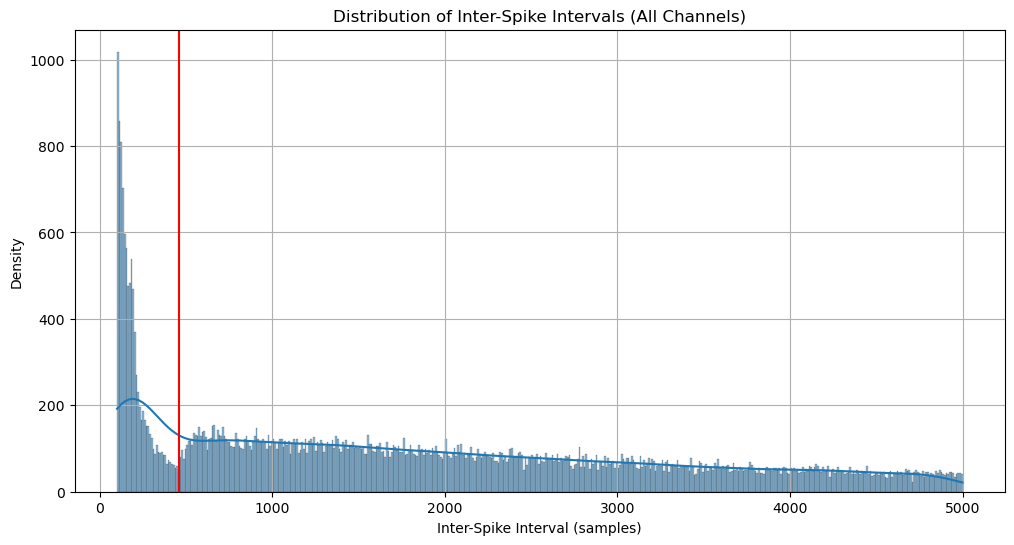

In [13]:
# Create a copy of all_spikes_df called interictal_spikes_df_copy_2

interictal_spikes_df_copy_2 = interictal_spikes_df.copy()

interictal_spikes_df_copy_2 = interictal_spikes_df_copy_2[
    interictal_spikes_df_copy_2["inter_spike_interval_samples"] > 100
]
interictal_spikes_df_copy_2 = interictal_spikes_df_copy_2[
    interictal_spikes_df_copy_2["inter_spike_interval_samples"] < 5000
]

plt.figure(figsize=(12, 6))
sns.histplot(
    interictal_spikes_df_copy_2["inter_spike_interval_samples"], kde=True, bins=500
)
plt.title("Distribution of Inter-Spike Intervals (All Channels)")
plt.xlabel("Inter-Spike Interval (samples)")
plt.ylabel("Density")
# Plot a vertical red line at 500
plt.axvline(x=460, color="red")
plt.grid(True)
plt.show()

## Cascade size distribution